In [1]:
!pip install ipython-autotime
%load_ext autotime

from matplotlib import pyplot as plt
import cProfile
import re
from time import perf_counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00
time: 671 µs (started: 2023-12-01 14:47:28 +00:00)


In [2]:
tests = [
    {
        "matrix": [
            [1, 2, -1, -4, -20],
            [-8, -3, 4, 2, 1],
            [3, 8, 10, 1, 3],
            [-4, -1, 1, 7, -6],
        ],
        "expected_result": 29,
        "subarray_indices": [(1, 1), (3, 3)], #top left and bottom right indices
    },

    {
        "matrix": [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
        "expected_result": 45,
        "subarray_indices": [(0, 0), (2, 2)],
    },
    {
        "matrix": [[-1, -2, -3], [-4, -5, -6], [-7, -8, -9]],
        "expected_result": -1,
        "subarray_indices": [(0, 0), (0, 0)],
    },
    {
        "matrix": [[1, -2, 3], [4, -5, 6], [7, -8, 9]],
        "expected_result": 18,
        "subarray_indices": [(0, 2), (2, 2)],
    },
    {
        "matrix": [[1, 2], [3, 4]],
        "expected_result": 10,
        "subarray_indices": [(0, 0), (1, 1)],
    },
    {
        "matrix": [
            [2, -1, 4, -6, 2],
            [-3, 2, -1, 4, -3],
            [1, -5, 2, -1, 5],
            [4, -2, 3, 7, -2],
        ],
        "expected_result": 14,
        "subarray_indices": [(0, 2), (3, 4)],
    },
    {
        "matrix": [[-2, 5, -1, 4], [8, -6, 3, 1], [2, 2, -4, -1], [-3, 2, 6, -1]],
        "expected_result": 15,
        "subarray_indices": [(0, 0), (3, 3)],
    },
    {
        "matrix": [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]],
        "expected_result": 78,
        "subarray_indices": [(0, 0), (3, 2)],
    },
    {
        "matrix": [[-1, -2, -3], [-4, -5, -6], [-7, -8, -9], [-10, -11, -12]],
        "expected_result": -1,
        "subarray_indices": [(0, 0), (0, 0)],
    },
    {
        "matrix": [[1, -2, 3], [4, -5, 6], [7, -8, 9]],
        "expected_result": 18,
        "subarray_indices": [(0, 2), (2, 2)],
    },
    {
        "matrix": [[1, 2], [3, 4]],
        "expected_result": 10,
        "subarray_indices": [(0, 0), (1, 1)],
    },
    {
        "matrix": [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]],
        "expected_result": 78,
        "subarray_indices": [(0, 0), (3, 2)],
    },
    {
        "matrix": [[-1, -2, -3], [-4, -5, -6], [-7, -8, -9], [-10, -11, -12]],
        "expected_result": -1,
        "subarray_indices": [(0, 0), (0, 0)],
    },
    {
        "matrix": [[1, -2, 3],
                   [4, -5, 6],
                   [7, -8, 9]],
        "expected_result": 18,
        "subarray_indices": [(0, 2), (2, 2)],
    },
    {
        "matrix": [[1, 2], [3, 4]],
        "expected_result": 10,
        "subarray_indices": [(0, 0), (1, 1)],
    },
    {
        "matrix": [
            [2, -1, 4, -6, 2],
            [-3, 2, -1, 4, -3],
            [1, -5, 2, -1, 5],
            [4, -2, 3, 7, -2],
        ],
        "expected_result": 14,
        "subarray_indices": [(0, 2), (3, 4)],
    },
    {
        "matrix": [
            [-2, 5, -1, 4],
            [8, -6, 3, 1],
            [2, 2, -4, -1],
            [-3, 2, 6, -1]],
        "expected_result": 15,
        "subarray_indices": [(0, 0), (3, 3)],
    },
    {
        "matrix": [[1, 1],
                   [1, 1], [1, 1], [1, 1]],
        "expected_result": 8,
        "subarray_indices": [(0, 0), (3, 1)],
    },
]


time: 2.14 ms (started: 2023-12-01 14:53:59 +00:00)


In [9]:
import random

def preprocess_sum_matrix(matrix):
    M, N = len(matrix), len(matrix[0])
    sum_matrix = [[0] * (N + 1) for _ in range(M + 1)]

    for i in range(1, M + 1):
        for j in range(1, N + 1):
            sum_matrix[i][j] = (sum_matrix[i - 1][j] + sum_matrix[i][j - 1] -
                                sum_matrix[i - 1][j - 1] + matrix[i - 1][j - 1])

    return sum_matrix

def submatrix_sum(sum_matrix, top, left, bottom, right):
    return (sum_matrix[bottom + 1][right + 1] - sum_matrix[top][right + 1] -
            sum_matrix[bottom + 1][left] + sum_matrix[top][left])

def random_submatrix_sum(matrix, num_iterations=100):
    M, N = len(matrix), len(matrix[0])
    sum_matrix = preprocess_sum_matrix(matrix)
    submatrices = [((top, left), (bottom, right))
                   for top in range(M) for bottom in range(top, M)
                   for left in range(N) for right in range(left, N)]

    random.shuffle(submatrices)
    max_sum = float('-inf')
    best_submatrix = None

    for submatrix in submatrices[:num_iterations]:
        top, left = submatrix[0]
        bottom, right = submatrix[1]

        current_sum = submatrix_sum(sum_matrix, top, left, bottom, right)

        if current_sum > max_sum:
            max_sum = current_sum
            best_submatrix = submatrix

    return max_sum, best_submatrix

for i in range(len(tests)):
  matrix = tests[i]
  result, best_submatrix = random_submatrix_sum(matrix["matrix"]) # Limiting the iterations to 100
  print("Maximum Sum of Contiguous Elements:", result)
  print("Best Submatrix:", best_submatrix)


#result, best_submatrix = random_submatrix_sum(matrix, 100)  # Limiting the iterations to 100
#print("Maximum Sum of Contiguous Elements:", result)
#print("Best Submatrix:", best_submatrix)


Maximum Sum of Contiguous Elements: 29
Best Submatrix: ((1, 1), (3, 3))
Maximum Sum of Contiguous Elements: 45
Best Submatrix: ((0, 0), (2, 2))
Maximum Sum of Contiguous Elements: -1
Best Submatrix: ((0, 0), (0, 0))
Maximum Sum of Contiguous Elements: 18
Best Submatrix: ((0, 2), (2, 2))
Maximum Sum of Contiguous Elements: 10
Best Submatrix: ((0, 0), (1, 1))
Maximum Sum of Contiguous Elements: 14
Best Submatrix: ((1, 2), (3, 3))
Maximum Sum of Contiguous Elements: 15
Best Submatrix: ((0, 0), (3, 3))
Maximum Sum of Contiguous Elements: 78
Best Submatrix: ((0, 0), (3, 2))
Maximum Sum of Contiguous Elements: -1
Best Submatrix: ((0, 0), (0, 0))
Maximum Sum of Contiguous Elements: 18
Best Submatrix: ((0, 2), (2, 2))
Maximum Sum of Contiguous Elements: 10
Best Submatrix: ((0, 0), (1, 1))
Maximum Sum of Contiguous Elements: 78
Best Submatrix: ((0, 0), (3, 2))
Maximum Sum of Contiguous Elements: -1
Best Submatrix: ((0, 0), (0, 0))
Maximum Sum of Contiguous Elements: 18
Best Submatrix: ((0, 2), 

In [7]:
count = []
# function to benchmark
def task():

    for i in range(len(tests)):
      matrix = tests[i]
      random_submatrix_sum(matrix["matrix"])

if __name__ == '__main__':
    # run 3 times and record the durations
    times = list()
    for i in range(10):
        count.append(i+1)
        # record start time
        time_start = perf_counter()
        # run the task
        task()
        # calculate the duration
        time_duration = perf_counter() - time_start
        # report the duration
        print(f'>took {time_duration:.3f} seconds')
        # store the duration
        times.append(time_duration)
    # report the average duration
    time_average = sum(times) / 10.0
    print(f'Average time {time_average:.3f} seconds')

>took 0.002 seconds
>took 0.003 seconds
>took 0.002 seconds
>took 0.002 seconds
>took 0.002 seconds
>took 0.002 seconds
>took 0.001 seconds
>took 0.001 seconds
>took 0.001 seconds
>took 0.002 seconds
Average time 0.002 seconds
time: 25.5 ms (started: 2023-12-01 15:01:34 +00:00)


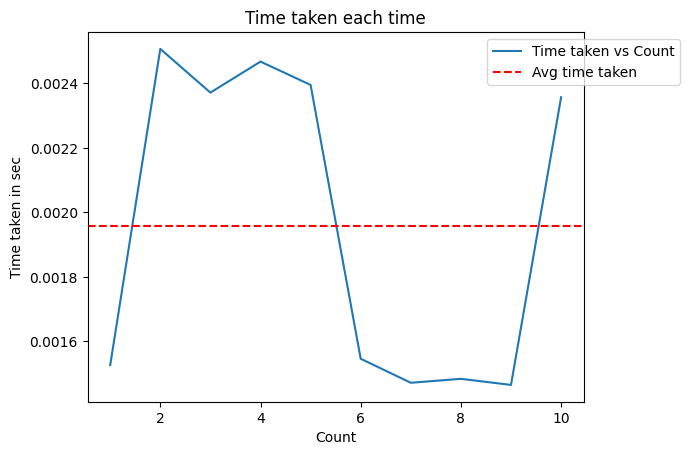

time: 292 ms (started: 2023-12-01 15:01:40 +00:00)


In [8]:
plt.plot(count,times,label="Time taken vs Count")
plt.axhline(y = time_average, color = 'r', linestyle = '--',label="Avg time taken")
plt.xlabel("Count")
plt.ylabel("Time taken in sec")
plt.title('Time taken each time')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.show()